In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from os import chdir
import numpy as np
import pickle
import scipy.stats as stats
import os


In [2]:
def clipAndNormalize(features, saveScalerPath = None):
    #clip the features to the range of the training data
    #clip outliers to 1st and 99th percentile
    features['danceability'] = features['danceability'].clip(lower=features['danceability'].quantile(0.01), upper=features['danceability'].quantile(0.99))
    features['energy'] = features['energy'].clip(lower=features['energy'].quantile(0.01), upper=features['energy'].quantile(0.99))
    features['loudness'] = features['loudness'].clip(lower=features['loudness'].quantile(0.01), upper=features['loudness'].quantile(0.99))
    features['speechiness'] = features['speechiness'].clip(lower=features['speechiness'].quantile(0.01), upper=features['speechiness'].quantile(0.99))
    features['acousticness'] = features['acousticness'].clip(lower=features['acousticness'].quantile(0.01), upper=features['acousticness'].quantile(0.99))
    features['instrumentalness'] = features['instrumentalness'].clip(lower=features['instrumentalness'].quantile(0.01), upper=features['instrumentalness'].quantile(0.99))
    features['liveness'] = features['liveness'].clip(lower=features['liveness'].quantile(0.01), upper=features['liveness'].quantile(0.99))
    features['valence'] = features['valence'].clip(lower=features['valence'].quantile(0.01), upper=features['valence'].quantile(0.99))
    features['tempo'] = features['tempo'].clip(lower=features['tempo'].quantile(0.01), upper=features['tempo'].quantile(0.99))
    features['duration_ms'] = features['duration_ms'].clip(lower=features['duration_ms'].quantile(0.01), upper=features['duration_ms'].quantile(0.99))
    features['time_signature'] = features['time_signature'].clip(lower=features['time_signature'].quantile(0.01), upper=features['time_signature'].quantile(0.99))

    columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

    for i in columns_to_log:
        if i == 'loudness':
            features[i] = features[i] + 60
        features[i] = np.log(features[i]+1)

    
    #normalize the data
    scaler = StandardScaler()

    #if id is a column, drop it
    if 'id' in features.columns:
        #fit on all columns except the track id
        rawfeatures = features.drop(['id'], axis=1)
    else:
        rawfeatures = features
    preprocessedFeatures = scaler.fit_transform(rawfeatures)

    preprocessedFeaturesDF = pd.DataFrame(preprocessedFeatures, columns=rawfeatures.columns)

    #apply z-score normalization
    for i in columns_to_log:
        preprocessedFeaturesDF[i] = stats.zscore(preprocessedFeaturesDF[i])
        preprocessedFeaturesDF.clip(lower=-2.7, upper=2.7, inplace=True)


    if saveScalerPath is not None:
        pickle.dump(scaler, open(saveScalerPath, 'wb'))
    #preprocessedFeaturesDF = pd.DataFrame(preprocessedFeatures, columns=rawfeatures.columns)

    return preprocessedFeaturesDF, preprocessedFeatures

In [3]:
def makeCategorical(df):
    mood_order=['sad','angry','energetic','excited','happy','content','calm','depressed']
    mood_codes, mood_categories = pd.factorize(mood_order)
    
    # Create a categorical object with the desired order
    cat = pd.Categorical(df['mood'], categories=mood_order, ordered=True)

    # Get the integer codes of the categories
    codes = cat.codes

    # Add the codes as a new column to the dataframe
    df['mood_code'] = codes
    return df



In [4]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/Python Projects/IRL projects/Aspire - Affective Computing Project/Playlists Data/Audio Features/emotion joint data')

In [5]:
emotionsDF = pd.read_csv('Merged Emotions Data4.csv')

In [6]:
emotionsDF = makeCategorical(emotionsDF)

In [7]:
emotionsDF['mood_code'].value_counts()

7    3781
6    1218
0    1020
5     773
1     694
3     678
2     631
4     519
Name: mood_code, dtype: int64

In [8]:
# create a new df with only up to 500 songs per mood_code
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in emotionsDF['mood_code'].unique():
    df = emotionsDF[emotionsDF['mood_code']==i]
    #if the value count of the mood_code is larger than 500, sample 500
    if df['mood_code'].value_counts()[i] > 600:
        df = df.sample(n=600, random_state=42)
    #if the value count of the mood_code is less than 500, sample the value count
    else:
        df = df.sample(n=df['mood_code'].value_counts()[i], random_state=42)
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood_code'].value_counts()

1    600
6    600
5    600
7    600
2    600
3    600
0    600
4    519
Name: mood_code, dtype: int64

In [9]:
balancedDF.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,song,mood,genre,mood_code
381,0.848,0.520,5,-10.663,0,0.5010,0.002250,0.000799,0.679,0.304,149.996,spotify:track:2XSrt1dcuOXPgl3B4bxmBz,203897,4,Carrollton,angry,rap,1
666,0.713,0.698,10,-7.435,0,0.1680,0.180000,0.000001,0.304,0.480,124.973,spotify:track:1SSv8SA2OHfOUwLgb8yOum,180062,4,Cheat Cxdes,angry,rap,1
257,0.757,0.423,1,-2.311,1,0.0527,0.000004,0.897000,0.118,0.125,130.058,spotify:track:0A8Mrg7ButLr17K3A0R61D,133308,4,TOTALITARIANISM,angry,EDM,1
338,0.516,0.515,1,-13.005,1,0.2790,0.033600,0.000002,0.119,0.396,95.971,spotify:track:583TaS41X2JJGKoGXnTY3l,107159,4,KILLTHEPHARAOH,angry,rap,1
319,0.618,0.836,6,-4.750,0,0.0813,0.002400,0.000000,0.363,0.397,175.060,spotify:track:7CMy59461Q3pgsPZ4Cj8CP,89143,4,EASE,angry,rap,1


In [10]:
rawfeatures = balancedDF.drop(['uri', 'song','mood','genre','mood_code'], axis=1)

In [11]:
rawfeaturesDF, rawfeatures = clipAndNormalize(rawfeatures,saveScalerPath="C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2/scaler4.pkl" )

In [12]:
rawfeaturesDF.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.488028,-0.324204,-0.078631,-0.664186,-1.272304,2.700000,-0.952933,-0.493081,2.700000,-0.541971,0.926476,0.264184,0.172931
1,0.553962,0.367703,1.309033,0.061950,-1.272304,0.661370,-0.244509,-0.496604,1.016053,0.209154,0.062095,-0.200122,0.172931
2,0.858399,-0.736215,-1.188763,1.129228,0.785976,-0.530739,-0.962075,2.332466,-0.475501,-1.305900,0.237749,-1.110890,0.172931
3,-0.809082,-0.344790,-1.188763,-1.220784,0.785976,1.702663,-0.819289,-0.496603,-0.466836,-0.149338,-0.939734,-1.620273,0.172931
4,-0.103343,0.855909,0.198902,0.633346,-1.272304,-0.223283,-0.952284,-0.496610,1.444942,-0.145070,1.792274,-1.971225,0.172931


In [13]:
y = balancedDF['mood_code']

In [14]:
#set it to categorical
y = y.astype('category')

In [15]:
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(rawfeatures, y, test_size=0.2, random_state=42, stratify=y)


In [21]:
def offByOne(y_test_standard, y_pred,digits=3):
    #compare y_test_standard with y_pred_list. If y_pred_list is +-1 from y_test_standard, then it change it to be the same as y_test_standard
    y_test_standard_list=list(y_test_standard)
    y_pred_list = list(y_pred)
    for id in range(len(y_test_standard_list)):
        if y_test_standard_list[id] != 0 and y_test_standard_list[id] != 7:
            if y_pred_list[id] == y_test_standard_list[id] - 1 or y_pred_list[id] == y_test_standard_list[id] + 1:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 0:
            if y_pred_list[id] ==  1 or y_pred_list[id] == 7:
                y_pred_list[id] = y_test_standard_list[id]
        elif y_test_standard_list[id] == 7:
            if y_pred_list[id] ==  0 or y_pred_list[id] == 6:
                y_pred_list[id] = y_test_standard_list[id]
    print(classification_report(y_test_standard_list, y_pred_list,digits = digits, target_names=['sad','angry','energetic','excited','happy','content','calm','depressed']))
    return

## skip when getting RF model

In [17]:

# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256,128),random_state=42,early_stopping=True)

In [18]:
# Train the model on the resampled data
mlp.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred = mlp.predict(X_test_standard)

# Evaluate the model performance of micro-averaged F1 score

print(classification_report(y_test_standard, y_pred))


              precision    recall  f1-score   support

           0       0.32      0.41      0.36       120
           1       0.58      0.68      0.62       120
           2       0.58      0.59      0.58       120
           3       0.34      0.38      0.36       120
           4       0.36      0.41      0.39       104
           5       0.43      0.25      0.32       120
           6       0.63      0.62      0.63       120
           7       0.33      0.23      0.27       120

    accuracy                           0.45       944
   macro avg       0.44      0.45      0.44       944
weighted avg       0.45      0.45      0.44       944



In [22]:
offByOne(y_test_standard, y_pred)

              precision    recall  f1-score   support

         sad      0.478     0.542     0.508       120
       angry      0.711     0.800     0.753       120
   energetic      0.768     0.800     0.784       120
     excited      0.568     0.692     0.624       120
       happy      0.646     0.615     0.631       104
     content      0.683     0.467     0.554       120
        calm      0.885     0.833     0.858       120
   depressed      0.713     0.642     0.675       120

    accuracy                          0.675       944
   macro avg      0.682     0.674     0.673       944
weighted avg      0.682     0.675     0.674       944



In [24]:
#save mlp model as MLP3.pkl in the folder C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v1.2
folder_path = "C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v1.2"

with open(os.path.join(folder_path, "MLP3.pkl"), 'wb') as f:
    pickle.dump(mlp, f)

In [136]:
#svm = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm =SVC(kernel='poly', degree=3,class_weight='balanced', random_state=42)


In [137]:
# Train the model
svm.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_SVM = svm.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.34      0.44      0.38       120
           1       0.70      0.57      0.63       120
           2       0.62      0.57      0.60       120
           3       0.35      0.33      0.34       120
           4       0.32      0.67      0.43       104
           5       0.47      0.28      0.35       120
           6       0.62      0.57      0.59       120
           7       0.33      0.18      0.24       120

    accuracy                           0.45       944
   macro avg       0.47      0.45      0.45       944
weighted avg       0.47      0.45      0.45       944



In [138]:
offByOne(y_test_standard, y_pred_SVM)

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       120
           1       0.83      0.73      0.78       120
           2       0.80      0.72      0.75       120
           3       0.62      0.73      0.67       120
           4       0.50      0.78      0.61       104
           5       0.71      0.54      0.62       120
           6       0.86      0.79      0.83       120
           7       0.77      0.62      0.69       120

    accuracy                           0.68       944
   macro avg       0.70      0.68      0.68       944
weighted avg       0.70      0.68      0.68       944



In [151]:
#use a decision tree
from sklearn.tree import DecisionTreeClassifier

# Initialize the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_DT = dt.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_DT))

offByOne(y_test_standard, y_pred_DT)

              precision    recall  f1-score   support

           0       0.32      0.29      0.30       120
           1       0.42      0.45      0.43       120
           2       0.51      0.54      0.53       120
           3       0.27      0.29      0.28       120
           4       0.31      0.32      0.31       104
           5       0.27      0.21      0.23       120
           6       0.52      0.55      0.53       120
           7       0.25      0.25      0.25       120

    accuracy                           0.36       944
   macro avg       0.36      0.36      0.36       944
weighted avg       0.36      0.36      0.36       944

              precision    recall  f1-score   support

           0       0.55      0.52      0.53       120
           1       0.64      0.70      0.67       120
           2       0.76      0.80      0.78       120
           3       0.50      0.53      0.52       120
           4       0.61      0.61      0.61       104
           5       0.53 

## RF model and onwards

In [20]:
# use a random forest classifier
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=10000, random_state=42)

# Train the model
rf.fit(X_train_standard, y_train_standard)



RandomForestClassifier(n_estimators=10000, random_state=42)

In [21]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.438     0.467     0.452       120
           1      0.620     0.667     0.643       120
           2      0.599     0.708     0.649       120
           3      0.403     0.400     0.402       120
           4      0.475     0.538     0.505       104
           5      0.427     0.342     0.380       120
           6      0.618     0.742     0.674       120
           7      0.397     0.225     0.287       120

    accuracy                          0.511       944
   macro avg      0.497     0.511     0.499       944
weighted avg      0.497     0.511     0.499       944

              precision    recall  f1-score   support

           0      0.586     0.567     0.576       120
           1      0.738     0.800     0.768       120
           2      0.782     0.867     0.822       120
           3      0.599     0.708     0.649       120
           4      0.722     0.673     0.697       104
           5      0.642 

In [22]:
# use a random forest classifier
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
rf.fit(X_train_standard, y_train_standard)



RandomForestClassifier(n_estimators=1000, random_state=42)

In [28]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.433     0.458     0.445       120
           1      0.614     0.675     0.643       120
           2      0.592     0.700     0.641       120
           3      0.397     0.383     0.390       120
           4      0.471     0.548     0.507       104
           5      0.440     0.333     0.379       120
           6      0.614     0.742     0.672       120
           7      0.386     0.225     0.284       120

    accuracy                          0.507       944
   macro avg      0.493     0.508     0.495       944
weighted avg      0.493     0.507     0.495       944

              precision    recall  f1-score   support

           0      0.593     0.583     0.588       120
           1      0.740     0.808     0.773       120
           2      0.784     0.875     0.827       120
           3      0.604     0.700     0.649       120
           4      0.713     0.692     0.702       104
           5      0.663 

In [25]:
chdir('C:/Users/mlar5/OneDrive/Desktop/Code Folder/198 Senior Design/Models/Spotipy v2')

In [29]:
filename = 'rf2.pkl'
#check if the file exists
if os.path.exists(filename)==False:
    pickle.dump(rf, open(filename, 'wb'))

In [162]:
# Make predictions on the test set
y_pred_RF = rf.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_RF,digits=3))

print(offByOne(y_test_standard, y_pred_RF))

              precision    recall  f1-score   support

           0      0.424     0.442     0.433       120
           1      0.634     0.692     0.661       120
           2      0.618     0.742     0.674       120
           3      0.376     0.392     0.384       120
           4      0.448     0.500     0.473       104
           5      0.460     0.333     0.386       120
           6      0.616     0.750     0.677       120
           7      0.386     0.225     0.284       120

    accuracy                          0.510       944
   macro avg      0.495     0.509     0.497       944
weighted avg      0.496     0.510     0.497       944

              precision    recall  f1-score   support

           0      0.590     0.575     0.582       120
           1      0.744     0.825     0.783       120
           2      0.797     0.883     0.838       120
           3      0.599     0.708     0.649       120
           4      0.740     0.712     0.725       104
           5      0.689 

# reviewing data distibution to determine the ranges to clip

In [32]:
# create a new df with only up to 500 songs per mood_code
# this is to balance the data

balancedDF = pd.DataFrame(columns=emotionsDF.columns)

for i in emotionsDF['mood_code'].unique():
    df = emotionsDF[emotionsDF['mood_code']==i]
    #if the value count of the mood_code is larger than 500, sample 500
    if df['mood_code'].value_counts()[i] > 600:
        df = df.sample(n=600, random_state=42)
    #if the value count of the mood_code is less than 500, sample the value count
    else:
        df = df.sample(n=df['mood_code'].value_counts()[i])
    balancedDF = pd.concat([balancedDF, df])

balancedDF['mood_code'].value_counts()

1    600
6    600
5    600
7    600
2    600
3    600
0    600
4    519
Name: mood_code, dtype: int64

In [20]:
print('lower danceability',balancedDF['danceability'].quantile(0.01))
print('upper danceability',balancedDF['danceability'].quantile(0.99))
print('lower energy',balancedDF['energy'].quantile(0.01))
print('upper energy',balancedDF['energy'].quantile(0.99))
print('lower loudness',balancedDF['loudness'].quantile(0.01))
print('upper loudness',balancedDF['loudness'].quantile(0.99))
print('lower speechiness',balancedDF['speechiness'].quantile(0.01))
print('upper speechiness',balancedDF['speechiness'].quantile(0.99))
print('lower acousticness',balancedDF['acousticness'].quantile(0.01))
print('upper acousticness',balancedDF['acousticness'].quantile(0.99))
print('lower instrumentalness',balancedDF['instrumentalness'].quantile(0.01))
print('upper instrumentalness',balancedDF['instrumentalness'].quantile(0.99))
print('lower liveness',balancedDF['liveness'].quantile(0.01))
print('upper liveness',balancedDF['liveness'].quantile(0.99))
print('lower valence',balancedDF['valence'].quantile(0.01))
print('upper valence',balancedDF['valence'].quantile(0.99))
print('lower tempo',balancedDF['tempo'].quantile(0.01))
print('upper tempo',balancedDF['tempo'].quantile(0.99))
print('lower duration_ms',balancedDF['duration_ms'].quantile(0.01))
print('upper duration_ms',balancedDF['duration_ms'].quantile(0.99))
print('lower time_signature',balancedDF['time_signature'].quantile(0.01))
print('upper time_signature',balancedDF['time_signature'].quantile(0.99))


lower danceability 0.25336000000000003
upper danceability 0.9188199999999997
lower energy 0.047536
upper energy 0.982
lower loudness -24.65708
upper loudness -0.8038200000000288
lower speechiness 0.0263
upper speechiness 0.5018199999999997
lower acousticness 0.00014072
upper acousticness 0.986
lower instrumentalness 0.0
upper instrumentalness 0.951
lower liveness 0.044836
upper liveness 0.7224599999999991
lower valence 0.038318
upper valence 0.9348199999999998
lower tempo 66.34576
upper tempo 189.87784
lower duration_ms 86120.0
upper duration_ms 341848.79999999976
lower time_signature 3.0
upper time_signature 5.0


<ipython-input-34-4eebaf6a8128>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(balancedDF['danceability'], ax=ax[0, 0])
<ipython-input-34-4eebaf6a8128>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(balancedDF['energy'], ax=ax[0, 1])
<ipython-input-34-4eebaf6a8128>:7: UserWarning: 

`distplo

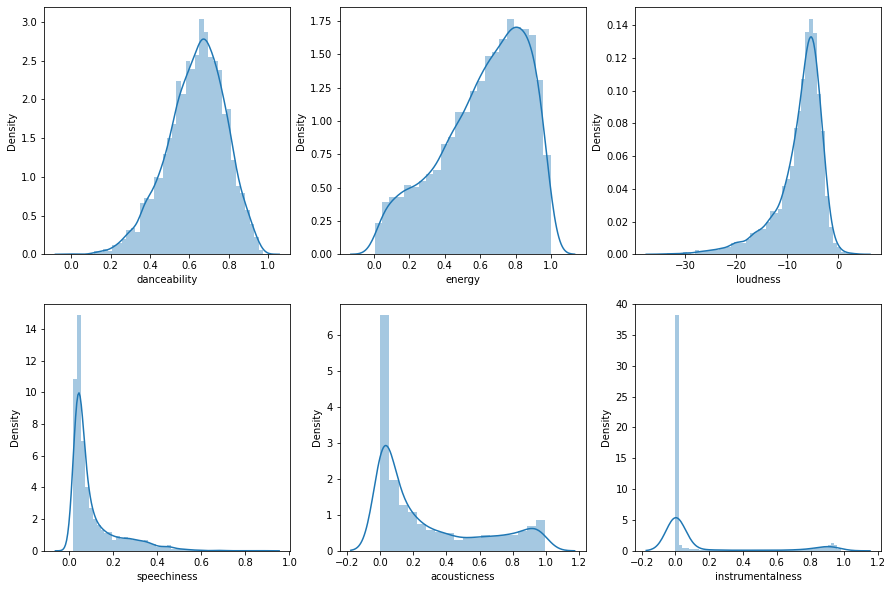

In [34]:
#from balancedDF, plot the distribution of the numerical features

#plot the distribution of the numerical features
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.distplot(balancedDF['danceability'], ax=ax[0, 0])
sns.distplot(balancedDF['energy'], ax=ax[0, 1])
sns.distplot(balancedDF['loudness'], ax=ax[0, 2])
sns.distplot(balancedDF['speechiness'], ax=ax[1, 0])
sns.distplot(balancedDF['acousticness'], ax=ax[1, 1])
sns.distplot(balancedDF['instrumentalness'], ax=ax[1, 2])



<ipython-input-36-ff164a45912d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(balancedDF['liveness'], ax=ax[0, 0])
<ipython-input-36-ff164a45912d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(balancedDF['valence'], ax=ax[0, 1])
<ipython-input-36-ff164a45912d>:5: UserWarning: 

`distplot` 

<AxesSubplot: xlabel='time_signature', ylabel='Density'>

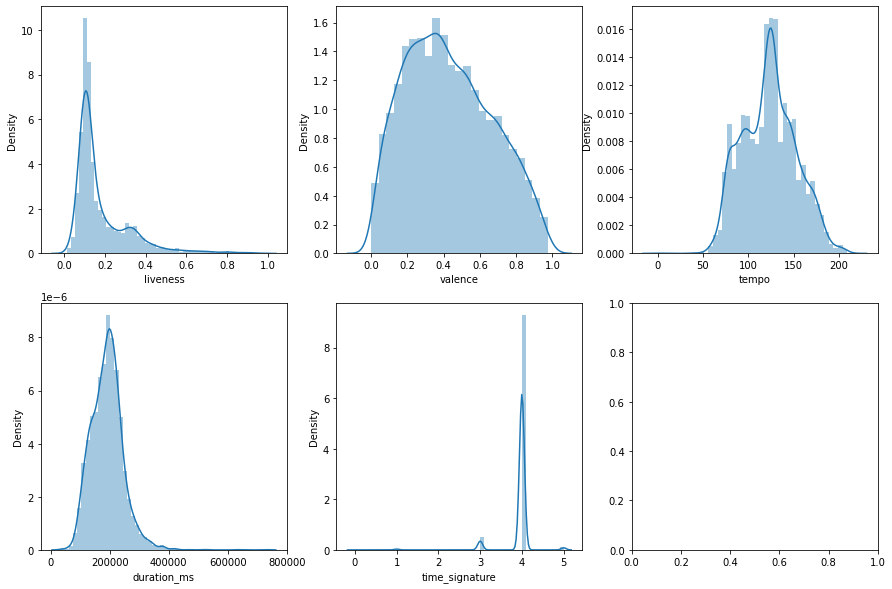

In [36]:
#plot more distributions
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.distplot(balancedDF['liveness'], ax=ax[0, 0])
sns.distplot(balancedDF['valence'], ax=ax[0, 1])
sns.distplot(balancedDF['tempo'], ax=ax[0, 2])
sns.distplot(balancedDF['duration_ms'], ax=ax[1, 0])
sns.distplot(balancedDF['time_signature'], ax=ax[1, 1])



# everything else that can be skipped

In [150]:
# use a bagging classifier
from sklearn.ensemble import BaggingClassifier
base_estimator = RandomForestClassifier(n_estimators=100,  random_state=42)

bagging = BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Train the model
bagging.fit(X_train_standard, y_train_standard)

# Make predictions on the test set
y_pred_bagging = bagging.predict(X_test_standard)

# Evaluate the model performance
print(classification_report(y_test_standard, y_pred_bagging))

print(offByOne(y_test_standard, y_pred_bagging))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44       120
           1       0.61      0.64      0.63       120
           2       0.56      0.73      0.63       120
           3       0.36      0.38      0.37       120
           4       0.45      0.47      0.46       104
           5       0.44      0.32      0.37       120
           6       0.59      0.73      0.65       120
           7       0.42      0.19      0.26       120

    accuracy                           0.49       944
   macro avg       0.48      0.49      0.48       944
weighted avg       0.48      0.49      0.48       944

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       120
           1       0.75      0.82      0.78       120
           2       0.74      0.92      0.82       120
           3       0.60      0.69      0.64       120
           4       0.74      0.69      0.72       104
           5       0.67 

In [139]:
rawfeaturesDF.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,4.719000e+03,4.719000e+03,4.719000e+03,4719.000000,4.719000e+03,4719.000000,4.719000e+03,4.719000e+03,4719.000000,4.719000e+03,4.719000e+03,4719.000000,4719.000000
mean,-1.806847e-16,4.818260e-17,2.258559e-18,0.010312,8.733096e-17,-0.004199,-4.818260e-17,2.409130e-17,-0.019021,-2.409130e-17,7.408074e-16,-0.003166,0.039614
std,1.000106e+00,1.000106e+00,1.000106e+00,0.970356,1.000106e+00,0.988430,1.000106e+00,1.000106e+00,0.938612,1.000106e+00,1.000106e+00,0.991136,0.730117
min,-2.626290e+00,-2.650139e+00,-1.466296e+00,-2.700000,-1.272304e+00,-0.822051,-9.620748e-01,-4.966097e-01,-1.131471,-1.675838e+00,-1.963093e+00,-2.030113,-2.700000
25%,-6.430258e-01,-5.694192e-01,-9.112302e-01,-0.359291,-1.272304e+00,-0.687614,-8.627452e-01,-4.966097e-01,-0.642511,-8.151080e-01,-7.994878e-01,-0.718047,0.172931
50%,9.730795e-02,2.375703e-01,-7.863139e-02,0.291734,7.859758e-01,-0.464468,-4.323762e-01,-4.965456e-01,-0.440887,-1.109277e-01,2.807005e-02,0.019788,0.172931
75%,7.200185e-01,7.874747e-01,7.539674e-01,0.668497,7.859758e-01,0.312414,8.024322e-01,-3.980784e-01,0.410344,7.468920e-01,7.028076e-01,0.601831,0.172931
max,1.978032e+00,1.333987e+00,1.586566e+00,1.425457,7.859758e-01,2.700000,2.014439e+00,2.456488e+00,2.700000,2.150217e+00,2.304133e+00,2.700000,2.700000


In [140]:
#get the value counts of liveness for each range of .1
rawfeaturesDF.instrumentalness.value_counts()

-0.496610    1833
 2.456488      51
 2.394912       9
 2.273849       9
 2.337122       8
             ... 
-0.435615       1
-0.496605       1
-0.494180       1
-0.496444       1
-0.496575       1
Name: instrumentalness, Length: 1825, dtype: int64

In [141]:
for i in rawfeaturesDF.columns:
    
    #print the skewness
    print('Skewness of', i, ':', rawfeaturesDF[i].skew())
    #print the kurtosis
    print('Kurtosis of', i, ':', rawfeaturesDF[i].kurtosis())


Skewness of danceability : -0.3790013234646256
Kurtosis of danceability : -0.24204525427561618
Skewness of energy : -0.8722964365125826
Kurtosis of energy : -0.03691040475747487
Skewness of key : 0.025717266379693703
Kurtosis of key : -1.3135427678539886
Skewness of loudness : -1.2856288600200025
Kurtosis of loudness : 1.1268516344383648
Skewness of mode : -0.48648263216030496
Kurtosis of mode : -1.7640824793104508
Skewness of speechiness : 1.4838539688683554
Kurtosis of speechiness : 1.040004392815956
Skewness of acousticness : 0.790513089978876
Kurtosis of acousticness : -0.8641791205147773
Skewness of instrumentalness : 1.7211497071039277
Kurtosis of instrumentalness : 1.1555240243514109
Skewness of liveness : 1.3518366626195617
Kurtosis of liveness : 0.9558535610347372
Skewness of valence : 0.28303698225385904
Kurtosis of valence : -0.8577073949393137
Skewness of tempo : 0.11899291526596477
Kurtosis of tempo : -0.6331288389966057
Skewness of duration_ms : 0.29520795140609724
Kurtos

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


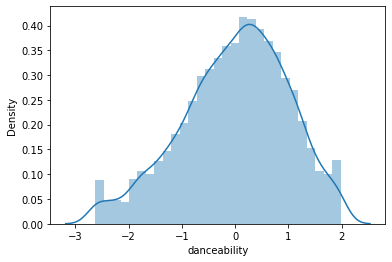

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


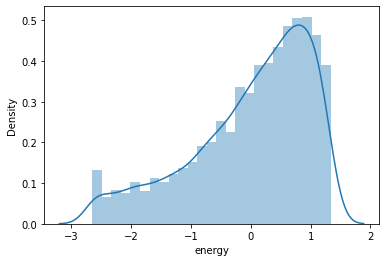

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


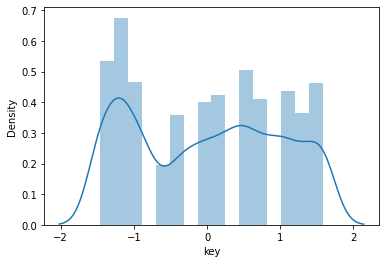

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


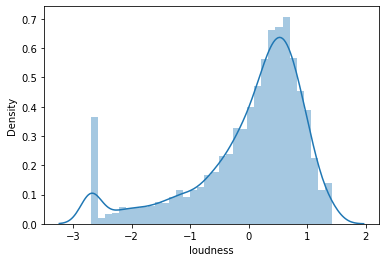

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


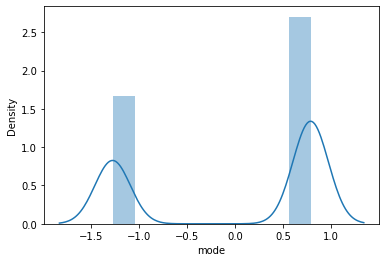

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


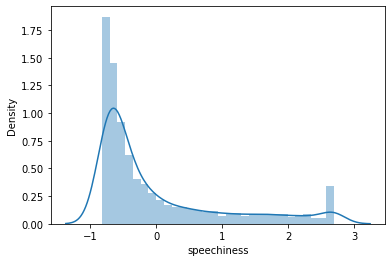

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


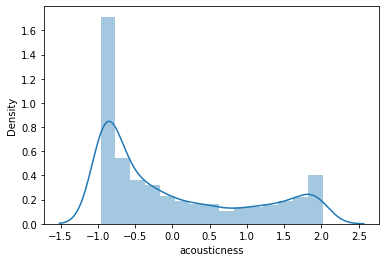

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


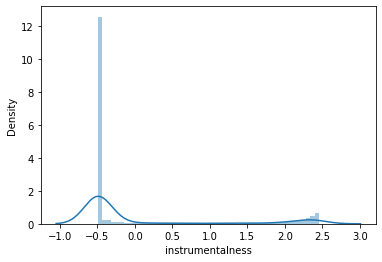

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


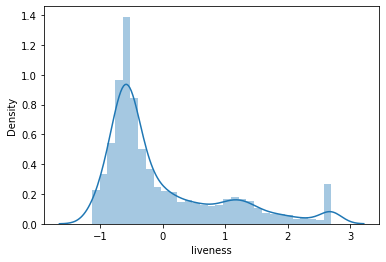

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


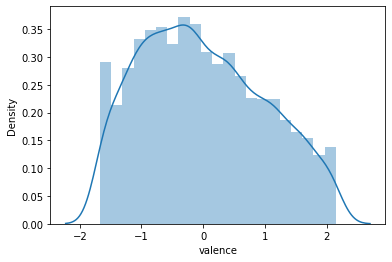

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


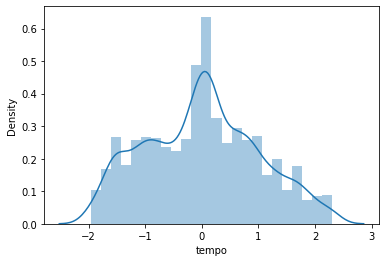

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


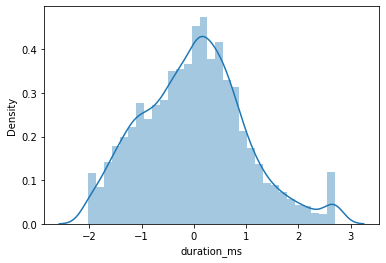

<ipython-input-142-f488e22308de>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rawfeaturesDF[i])


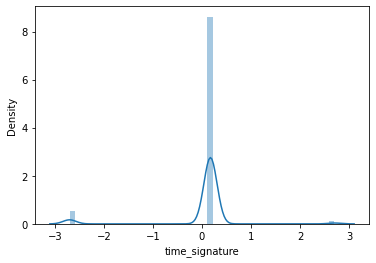

In [142]:
#plot the distribution of the features
for i in rawfeaturesDF.columns:
    sns.distplot(rawfeaturesDF[i])
    plt.show()

In [143]:
# apply log transformation to the features
logfeaturesDF = rawfeaturesDF.copy(deep=True)

columns_to_log=['liveness', 'instrumentalness', 'acousticness', 'speechiness','loudness','energy']

for i in columns_to_log:
    logfeaturesDF[i] = np.log(logfeaturesDF[i] + 1)

c:\Users\mlar5\anaconda3\envs\TextMining\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
